In [14]:
!pip install imblearn > /dev/null
!pip install sklearn > /dev/null

In [57]:
import tensorflow as tf
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras import Model
from tensorflow.keras.experimental import LinearModel
from collections import Counter
import seaborn as sns
import statistics

In [2]:
%config Completer.use_jedi = False

In [4]:
# Uncomment the following line to disable GPU
tf.config.set_visible_devices([], 'GPU')
tf.config.threading.set_inter_op_parallelism_threads(4)
tf.config.threading.set_intra_op_parallelism_threads(4)
print(tf.config.get_visible_devices())
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
1 Physical GPUs, 0 Logical GPUs


# Import parquet data

In [6]:
ds = pq.ParquetDataset("/var/log/fancontrol/featurelog")
ptable = ds.read().to_pandas()

In [13]:
#drop the few examples where power is negative
ptable = ptable[ptable['power'] >= 0.0]

### What is our distribution of idle values.. presumably very biased

In [17]:
cpu_idle = ptable['mean_cpu_idle'] = ptable['cpu_idle'].apply(statistics.mean)
sns.displot(ptable['mean_cpu_idle'], binwidth=0.01, log=True)

In [22]:
def group_idle(val):
    gval = 100.0 * val
    try:
        return int(gval)
    except:
        return 0

sampler_classes = ptable['mean_cpu_idle'].apply(group_idle)

In [46]:
from imblearn.under_sampling import RandomUnderSampler

In [44]:
cnt = Counter(sampler_classes)

In [49]:
rus = RandomUnderSampler(sampling_strategy={i: min(20000, cnt[i]) for i in range(0,101)})
x,y = rus.fit_resample(ptable, sampler_classes)

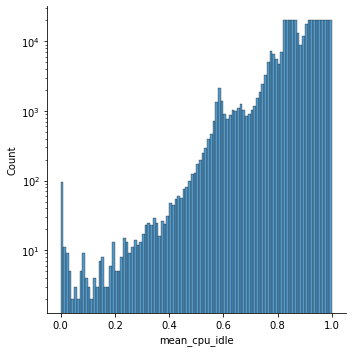

In [65]:
sns.displot(x['mean_cpu_idle'], binwidth=0.01, log=True)

In [79]:
from imblearn.over_sampling import RandomOverSampler
def group_idle20(val):
    gval = 20.0 * val - 0.0001
    try:
        return int(gval)
    except:
        return 0
sampler_classes = x['mean_cpu_idle'].apply(group_idle20)
cnt = Counter(sampler_classes)
ros = RandomOverSampler(sampling_strategy={i: max(100000, cnt[i]) for i in range(0,20)})

In [80]:
len(x), len(sampler_classes), Counter(sampler_classes)

(397781,
 397781,
 Counter({0: 131,
          1: 23,
          2: 20,
          3: 32,
          4: 46,
          5: 59,
          6: 117,
          7: 122,
          8: 267,
          9: 509,
          10: 1302,
          11: 6044,
          12: 4635,
          13: 5151,
          14: 8058,
          15: 27685,
          16: 74236,
          17: 71694,
          18: 97608,
          19: 100042}))

In [81]:
xp,y = ros.fit_resample(x, sampler_classes)

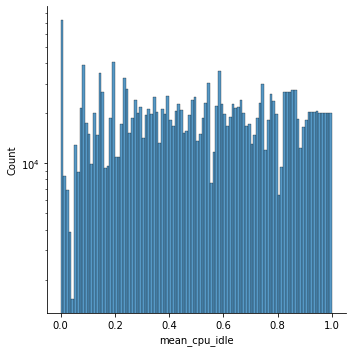

In [82]:
sns.displot(xp['mean_cpu_idle'], binwidth=0.01, log=True)

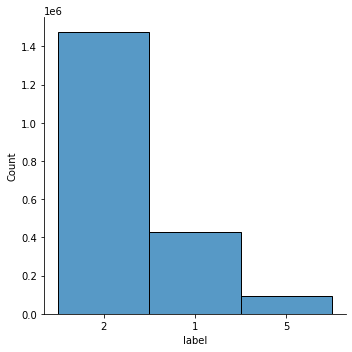

In [183]:
sns.displot(xp['label'])

In [194]:
xp['label'] = xp['label'].apply(lambda v: int(v)).values
sampler_classes = xp['label']
cnt = Counter(sampler_classes)
print(cnt)
ros = RandomOverSampler(sampling_strategy={i: max(1470000, cnt[i]) for i in [1,2,5]})
xpp,y = ros.fit_resample(xp, sampler_classes)

Counter({2: 1478457, 1: 426936, 5: 94649})


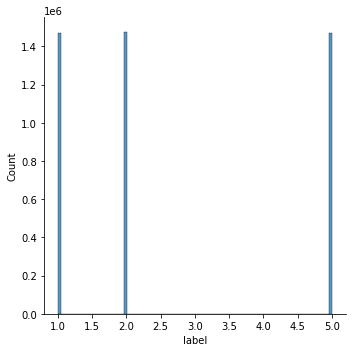

In [196]:
sns.displot(xpp['label'])

In [195]:
ptable = xpp

In [84]:
def feature_names():
    l = list(ptable.columns.values)
    l.remove('label')
    return l

def generator_types():
    return ({k: tf.float32 for k in feature_names()}, tf.float32)

def dim(val):
    return 1 if isinstance(val, float) or isinstance(val, int) else len(val)

def generator_shapes():
    _, row = next(ptable.iterrows())
    shapes = {k: (1, dim(row[k])) for k in feature_names()}
    return tuple([shapes, (1,)])

print(feature_names())
print(generator_types())
print(generator_shapes())

['timestamp', 'cpuinfo', 'profile', 'cpu_idle', 'cpu_user', 'cpu_system', 'cpu_nice', 'power_constraints', 'power', 'temp', 'fan_rpm', 'year', 'month', 'day', 'mean_cpu_idle', 'ig']
({'timestamp': tf.float32, 'cpuinfo': tf.float32, 'profile': tf.float32, 'cpu_idle': tf.float32, 'cpu_user': tf.float32, 'cpu_system': tf.float32, 'cpu_nice': tf.float32, 'power_constraints': tf.float32, 'power': tf.float32, 'temp': tf.float32, 'fan_rpm': tf.float32, 'year': tf.float32, 'month': tf.float32, 'day': tf.float32, 'mean_cpu_idle': tf.float32, 'ig': tf.float32}, tf.float32)
({'timestamp': (1, 1), 'cpuinfo': (1, 8), 'profile': (1, 1), 'cpu_idle': (1, 8), 'cpu_user': (1, 8), 'cpu_system': (1, 8), 'cpu_nice': (1, 8), 'power_constraints': (1, 2), 'power': (1, 1), 'temp': (1, 10), 'fan_rpm': (1, 1), 'year': (1, 1), 'month': (1, 1), 'day': (1, 1), 'mean_cpu_idle': (1, 1), 'ig': (1, 1)}, (1,))


In [118]:
def convert(key, value):
    if isinstance(value, float) or isinstance(value, int):
        return tf.reshape(tf.convert_to_tensor(value, tf.float32, name=key), (1, 1))
    return tf.reshape(tf.convert_to_tensor(value, tf.float32, name=key), (1, dim(value)))

def gen_generator(table):
    ptable = table
    def generator():
        for index, row in ptable.iterrows():
            f = {k: convert(k, row[k]) for k in feature_names()}
            l = tf.convert_to_tensor(list([float(row['label'])]), tf.float32, name='label')
            yield f, l
    return generator

In [119]:
all = tf.data.Dataset.from_generator(gen_generator(ptable), output_types=generator_types(), output_shapes=generator_shapes()) \
    .shuffle(10, reshuffle_each_iteration=False)
n = next(all.batch(2).as_numpy_iterator())
print(n)

({'timestamp': array([[[1.6377565e+09]],

       [[1.6377565e+09]]], dtype=float32), 'cpuinfo': array([[[2339.577, 2339.574, 2339.574, 2339.572, 2339.57 , 2339.567,
         2344.936, 2339.566]],

       [[2386.008, 2386.355, 2386.066, 2386.064, 2385.964, 2386.053,
         2386.064, 2387.912]]], dtype=float32), 'profile': array([[[1.]],

       [[1.]]], dtype=float32), 'cpu_idle': array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.03571429, 0.        ]],

       [[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.02173913]]], dtype=float32), 'cpu_user': array([[[0.8888889 , 0.962963  , 1.        , 0.7407407 , 0.9259259 ,
         0.89285713, 0.8214286 , 0.7407407 ]],

       [[0.8695652 , 0.8695652 , 0.9347826 , 0.9130435 , 0.93333334,
         0.8695652 , 0.84782606, 0.7826087 ]]], dtype=float32), 'cpu_system': array([[[0.11111111, 0.03703704, 0.        , 0.25925925, 0.07407407,
         0.10714286,

In [87]:
tf.shape(n[0]['temp']).numpy()

array([ 2,  1, 10], dtype=int32)

In [88]:
tf.shape(n[1]).numpy()

array([2, 1], dtype=int32)

In [89]:
import utils
train_dataset, test_dataset = utils.split_dataset(all, 8)

# Lets build a simple model

In [197]:
from tensorflow.keras import layers
from tensorflow import keras

In [327]:
class DenseBlock(layers.Layer):
    def __init__(self, units, activation='selu', dropout_rate=0.0, l2=0.0001):
        super().__init__()
        self.dense = layers.Dense(units, activation, kernel_regularizer=keras.regularizers.l2(l2))
        self.batchn = layers.BatchNormalization()
        self.dropout = layers.Dropout(dropout_rate)
    
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.batchn(x)
        x = self.dropout(x)
        return x

In [282]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
fit_label_transform = le.fit_transform(ptable['label'])
ptable['fit_label'] = fit_label_transform

In [290]:
tf.reshape(tf.convert_to_tensor(keras.utils.to_categorical(ptable['fit_label'])[0]), (1,3))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0., 1., 0.]], dtype=float32)>

In [302]:
def cat_gen_generator(table):
    ptable = table
    def generator():
        for index, row in ptable.iterrows():
            f = {k: convert(k, row[k]) for k in feature_names()}
            l = tf.reshape(tf.convert_to_tensor(keras.utils.to_categorical(row['fit_label'], num_classes=3), name='label'), (1, 3))
            yield f, l
    return generator
def generator_types():
    return ({k: tf.float32 for k in feature_names()}, tf.float32)
def generator_shapes():
    _, row = next(ptable.iterrows())
    shapes = {k: (1, dim(row[k])) for k in feature_names()}
    return tuple([shapes, (1, 3)])

In [307]:
all = tf.data.Dataset.from_generator(cat_gen_generator(ptable), output_types=generator_types(), output_shapes=generator_shapes()) \
    .shuffle(10, reshuffle_each_iteration=False)

In [339]:
train_dataset, test_dataset = utils.split_dataset(all, 8)

In [349]:
temp_input = Input(shape=(10,), name="temp")
cpu_idle_input = Input(shape=(8,), name="cpu_idle")
power_input = Input(shape=(1,), name="power")
fan_input = Input(shape=(1,), name="fan_rpm")
all_input = [power_input, temp_input] # , cpu_idle_input], fan_input]

lx = layers.concatenate(all_input)
lx = layers.BatchNormalization()(lx)
lx = DenseBlock(32)(lx)
lx = keras.layers.Dense(3, activation='softmax')(lx)

model=keras.Model(inputs=all_input, outputs=[lx])
optimizer = keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1)
model.compile(optimizer=optimizer,
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=["acc"])

In [350]:
model.fit(train_dataset,
          validation_data=test_dataset.take(1000),
          epochs=10, batch_size=1000,
          callbacks = [utils.lr,utils.es], steps_per_epoch=10000)

Epoch 1/10
10000/10000 [==============================] - 53s 5ms/step - loss: 0.3597 - acc: 0.9182 - val_loss: 0.3865 - val_acc: 0.9140
Epoch 2/10
10000/10000 [==============================] - 51s 5ms/step - loss: 0.5794 - acc: 0.8510 - val_loss: 0.3895 - val_acc: 0.9140
Epoch 3/10
10000/10000 [==============================] - 50s 5ms/step - loss: 0.6677 - acc: 0.8303 - val_loss: 0.3660 - val_acc: 0.9140
Epoch 4/10
10000/10000 [==============================] - 51s 5ms/step - loss: 0.5449 - acc: 0.8758 - val_loss: 0.3940 - val_acc: 0.9140
Epoch 5/10
 6644/10000 [==================>...........] - ETA: 11s - loss: 0.6713 - acc: 0.8275

KeyboardInterrupt: 

In [357]:
for layer in model.layers:
    print(layer.name)
    if layer.get_weights():
        print("  weights: " + str(layer.get_weights()[0]))
        print("  bias: " + str(layer.get_weights()[1]))

power
temp
concatenate_50
batch_normalization_172
  weights: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  bias: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
dense_block_128
  weights: [[ 4.56349888e-32  8.30489698e-33  1.84040053e-32  1.88553482e-32
   3.87252684e-32 -5.03828986e-32  3.92921682e-32 -3.32141219e-32
  -4.90692602e-32  1.08793060e-32  1.16255333e-32 -3.00686606e-32
   1.43011642e-32 -7.19868700e-33  2.16897736e-32 -1.54654796e-32
  -4.58054120e-32 -8.04992197e-33  1.35567706e-32  1.57645180e-34
   1.40462630e-33 -5.52283510e-32  5.84293867e-32 -5.55687448e-32
   9.20604711e-33 -1.95195128e-32 -3.15222534e-32  2.88904068e-32
   5.86942021e-32  4.14473196e-32 -1.21437618e-32 -5.17172258e-32]
 [ 2.63721687e-32 -5.57209772e-32 -5.40079410e-32 -5.01718856e-32
  -8.69709479e-33 -3.34246118e-32 -2.04229595e-32 -2.67443479e-32
   1.84734135e-33  5.05725000e-32 -3.24720235e-32  2.21463224e-32
  -1.43356679e-32  2.56382929e-32  2.74124401e-32 -2.87342365e-32
   4.04581587e-32 -4.81717967e-32  2.3182

In [131]:
# extract_sensors_tensor_names output
{'temp': ['temp1.temp1_input', 'Core 0.temp2_input', 'Core 1.temp3_input', 'Core 2.temp4_input', 'Core 3.temp5_input', 'Package id 0.temp1_input', 'temp1.temp1_input', 'Composite.temp1_input', 'Sensor 1.temp2_input', 'CPU.temp1_input'], 'fan_rpm': ['Fan1.fan1_input']}

{'temp': ['temp1.temp1_input',
  'Core 0.temp2_input',
  'Core 1.temp3_input',
  'Core 2.temp4_input',
  'Core 3.temp5_input',
  'Package id 0.temp1_input',
  'temp1.temp1_input',
  'Composite.temp1_input',
  'Sensor 1.temp2_input',
  'CPU.temp1_input'],
 'fan_rpm': ['Fan1.fan1_input']}

In [114]:
n[0]['temp']

array([[[65.  , 63.  , 66.  , 65.  , 64.  , 66.  , 48.  , 50.85, 50.85,
         65.  ]],

       [[66.  , 79.  , 80.  , 76.  , 80.  , 80.  , 54.  , 55.85, 55.85,
         66.  ]]], dtype=float32)

It appears that these four are the only ones that matter
'Core 0.temp2_input' 'CPU.temp1_input' 'Composite.temp1_input', 'Sensor 1.temp2_input' for the linear model

Let's save the model and then evaluate it on the test set

In [115]:
linear_model.save("clean_train")

INFO:tensorflow:Assets written to: clean_train/assets


In [132]:
print("Evaluate on test data")
results = linear_model.evaluate(test_dataset, batch_size=1024)
print("test loss, test acc:", results)

Evaluate on test data
102050/102050 [==============================] - 789s 8ms/step - loss: 0.0913
test loss, test acc: 0.09127047657966614


The loss a bit higher than the training loss. So we probably overfit that data.

But that's ok. Right now we're just trying to see if we can learn anything. i.e. there are some correlations to be had in the data.

In this setup we are really just trying to learn the heuristic and since that is non-linear we'll alway be a bit off with this linear model.

In [135]:
f = {'power': tf.reshape(tf.constant(5.0), (1,1)),
     'temp': tf.reshape(tf.constant([39., 33., 34., 34., 34., 38., 36., 42.85, 42.85, 39.]), (1, 10))}
linear_model.predict(f)

array([[1.018949]], dtype=float32)

In [136]:
model = tf.keras.models.load_model('/home/danielk/code/smart-fancontrol/features/clean_train')

In [137]:
model.predict(f)

array([[1.018949]], dtype=float32)

In [139]:
f = {'power': tf.reshape(tf.constant(5.0), (1,1)),
     'temp': tf.reshape(tf.constant([79., 33., 34., 34., 34., 38., 36., 92.85, 92.85, 69.]), (1, 10))}
model.predict(f)

array([[8.990961]], dtype=float32)

In [140]:
f = {'power': tf.reshape(tf.constant(5.0), (1,1)),
     'temp': tf.reshape(tf.constant([79., 33., 34., 34., 34., 38., 36., 92.85, 92.85, 89.]), (1, 10))}
model.predict(f)

array([[-1.9199204]], dtype=float32)

Some of what has been learned is bunk :) Higher temps should not make the fan go slower!